<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/01_Basic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Retrieval-Augmented Generation (RAG): LangChain Implementation
**Retrieval-Augmented Generation (RAG)** is the concept to provide LLMs with additional information from an external knowledge source.

This allows them to generate more accurate and contextual answers while reducing hallucinations.

RAG is a general methodology to connect LLMs to external data, using

(1) indexing (make external data retrievable),

(2) retrieval (fetch external data that is relevant to a query that we want the LLM to reason about,

(3) generation pass this to an LLM to generate an answer.


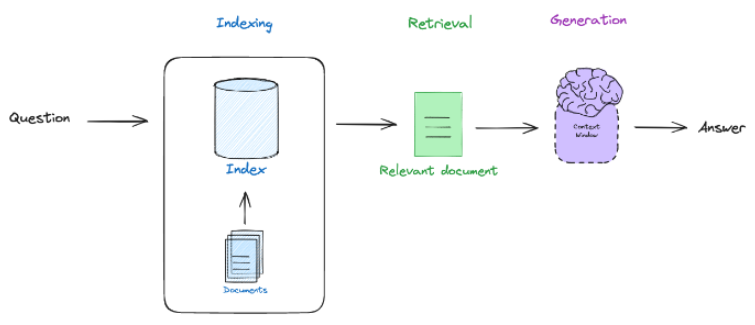

**Note:** This Notebook implements a RAG pipeline in Python using an AzureOpenAI LLM in combination with a FAISS vector store and an Azure OpenAI embedding model. LangChain is used for orchestration.

## Prerequisites
Make sure you have installed the required Python packages:

* langchain for orchestration
* openai for the embedding model and LLM
* faiss-cpu for the vectorstore

In [ ]:
!git clone https://github.com/amutharun/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 5.41 MiB | 18.89 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
!pip install -r /content/RAG/rag_requirements.txt

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

## Azure Configuration
Define relevant environment variables in a .env file

In [ ]:
import openai
# if directly using open ai api key
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_type = "openai"

In [ ]:
# Fetch the Azure Open AI env variables
GPT4_DEPLOYMENT_NAME = os.getenv('GPT4_DEPLOYMENT_NAME')
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

API_KEY = os.getenv('API_KEY')
API_BASE = os.getenv('API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')


EMBEDDING_API_KEY = os.getenv('API_KEY')
EMBEDDING_API_BASE = os.getenv('API_BASE')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

## RAG Process Flow
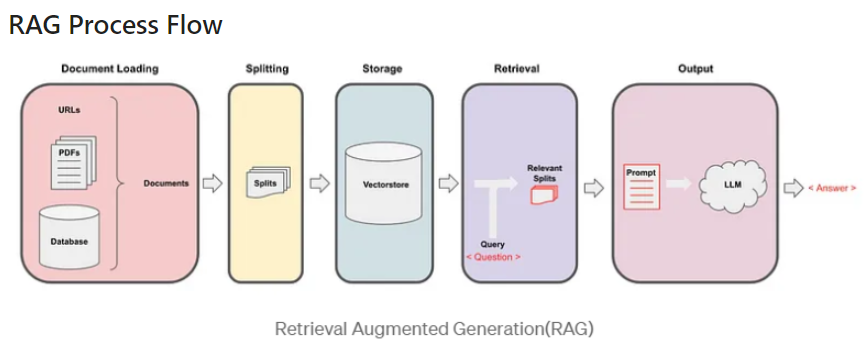

## Step1: Document Loading
We use LangChain’s document loaders for this purpose.

Document loaders deal with the specifics of accessing and converting data from a variety of different formats and sources into a standardized format.

We may have to load from structured data sources or unstructured data sources.

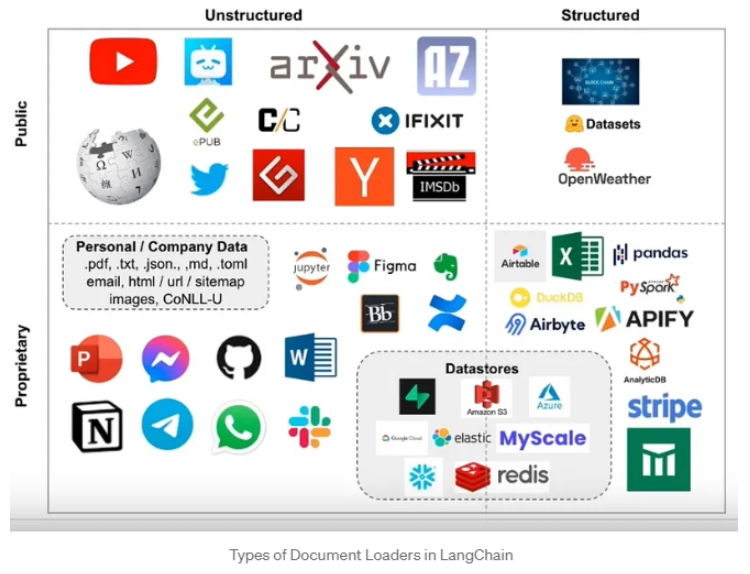

##### PyPDF DataLoader

In [ ]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path='/content/RAG/data/Microsoft_2023.pdf')
documents = loader.load()
len(documents)

116

## Step2: Document Splitting

Often times your document is too long (like a book) for your LLM. You need to split it up into chunks. Text splitters help with this.


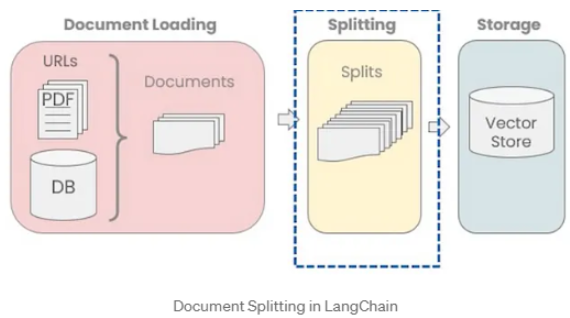

The input text is split based on a defined chunk size with some defined chunk overlap.

**Chunk Size** is a length function to measure the size of the chunk. This is often characters or tokens.

**Chunk Overlap** is used to have little overlap between two chunks and this allows for to have some notion of consistency between 2 chunks

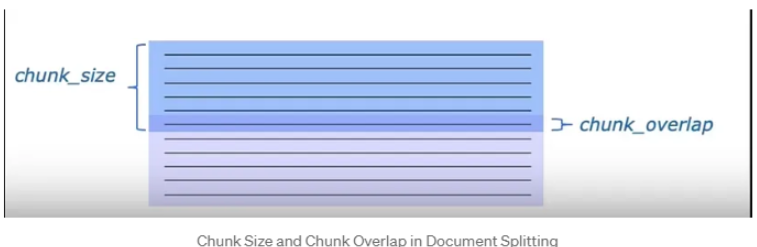

#### Example

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from IPython.display import Markdown

some_text = """When writing documents, writers will use document structure to group content. \
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  \
Paragraphs are often delimited with a carriage return or two carriage returns. \
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space.\
and words are separated by space."""


In [ ]:
# let's check the len of the text
len(some_text)

496

In [ ]:
Markdown(some_text)

When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. 

  Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.

Playground  : https://langchain-text-splitter.streamlit.app/

#### Type1 - Character Text Splitter
Implementation of splitting text that looks at characters.

In [ ]:
c_splitter = CharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separator = ' '  # CharacterTextSplitter uses space as a separator
)

c_splitter.split_text(some_text)

['When writing documents, writers will use document structure to group content. This can convey to the reader, which idea\'s are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also,',
 'have a space.and words are separated by space.']

In [ ]:
len(c_splitter.split_text(some_text))

2

chunk size is 450 hence it has made 2 chunks

#### Type2 - RecursiveCharacter Text Splitter
Implementation of splitting text that looks at characters. Recursively tries to split by different characters to find one that works.

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separators=["\n\n", "\n", " ", ""]   # We pass a list of separators to RecursiveCharacterText Splitter
)
r_splitter.split_text(some_text)

["When writing documents, writers will use document structure to group content. This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document.",
 'Paragraphs are often delimited with a carriage return or two carriage returns. Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.']

#### Type3 -  Token Text Splitter
Split based on token count

In [ ]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(chunk_size=1, chunk_overlap=0)

# text1 = "foo bar bazzy foo industrialization"
text_splitter.split_text(some_text)

['When',
 ' writing',
 ' documents',
 ',',
 ' writers',
 ' will',
 ' use',
 ' document',
 ' structure',
 ' to',
 ' group',
 ' content',
 '.',
 ' This',
 ' can',
 ' convey',
 ' to',
 ' the',
 ' reader',
 ',',
 ' which',
 ' idea',
 "'s",
 ' are',
 ' related',
 '.',
 ' For',
 ' example',
 ',',
 ' closely',
 ' related',
 ' ideas',
 ' are',
 ' in',
 ' sent',
 'ances',
 '.',
 ' Similar',
 ' ideas',
 ' are',
 ' in',
 ' paragraphs',
 '.',
 ' Par',
 'agraph',
 's',
 ' form',
 ' a',
 ' document',
 '.',
 ' ',
 '\n\n',
 ' ',
 ' Par',
 'agraph',
 's',
 ' are',
 ' often',
 ' delim',
 'ited',
 ' with',
 ' a',
 ' carriage',
 ' return',
 ' or',
 ' two',
 ' carriage',
 ' returns',
 '.',
 ' Car',
 'riage',
 ' returns',
 ' are',
 ' the',
 ' "',
 'back',
 'sl',
 'ash',
 ' n',
 '"',
 ' you',
 ' see',
 ' embedded',
 ' in',
 ' this',
 ' string',
 '.',
 ' Sent',
 'ences',
 ' have',
 ' a',
 ' period',
 ' at',
 ' the',
 ' end',
 ',',
 ' but',
 ' also',
 ',',
 ' have',
 ' a',
 ' space',
 '.',
 'and',
 ' words',
 

In [ ]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(chunk_size=3, chunk_overlap=1)

# text1 = "foo bar bazzyfoo industrialization"
text_splitter.split_text(some_text)

['When writing documents',
 ' documents, writers',
 ' writers will use',
 ' use document structure',
 ' structure to group',
 ' group content.',
 '. This can',
 ' can convey to',
 ' to the reader',
 ' reader, which',
 " which idea's",
 "'s are related",
 ' related. For',
 ' For example,',
 ', closely related',
 ' related ideas are',
 ' are in sent',
 ' sentances.',
 '. Similar ideas',
 ' ideas are in',
 ' in paragraphs.',
 '. Paragraph',
 'agraphs form',
 ' form a document',
 ' document. ',
 ' \n\n ',
 '  Paragraph',
 'agraphs are',
 ' are often delim',
 ' delimited with',
 ' with a carriage',
 ' carriage return or',
 ' or two carriage',
 ' carriage returns.',
 '. Carriage',
 'riage returns are',
 ' are the "',
 ' "backsl',
 'slash n',
 ' n" you',
 ' you see embedded',
 ' embedded in this',
 ' this string.',
 '. Sentences',
 'ences have a',
 ' a period at',
 ' at the end',
 ' end, but',
 ' but also,',
 ', have a',
 ' a space.',
 '.and words',
 ' words are separated',
 ' separated by sp

#### Type4 -  Context-aware splitting
Preserves header metadata in our chunks. It splits a markdown file based on the header or any subheaders and then it adds those headers as content to the metadata fields

In [ ]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

markdown_document = """# Title (H1)\n\n \
This is part of Title (H1)
## Chapter 1 (H2)\n\n \
I'm part of Chapter 1(H2) under Title (H1)\n\n \
### Section (H3) \n\n \
I'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1) \n\n
## Chapter 2(H2)\n\n \
I'm part of Chapter 2(H2) under Title (H1)"""

Let's see how the markdown doc looks like

In [ ]:
Markdown(markdown_document)

# Title (H1)

 This is part of Title (H1)
## Chapter 1 (H2)

 I'm part of Chapter 1(H2) under Title (H1)

 ### Section (H3) 

 I'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1) 


## Chapter 2(H2)

 I'm part of Chapter 2(H2) under Title (H1)

In [ ]:
# We define the hierarchy of headers to split on. First H1, then H2 followed by H3
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on) # define MarkdownHeaderTextSplitter
md_header_splits = markdown_splitter.split_text(markdown_document)

In [ ]:
# let's checkk the total number of splits
len(md_header_splits)

4

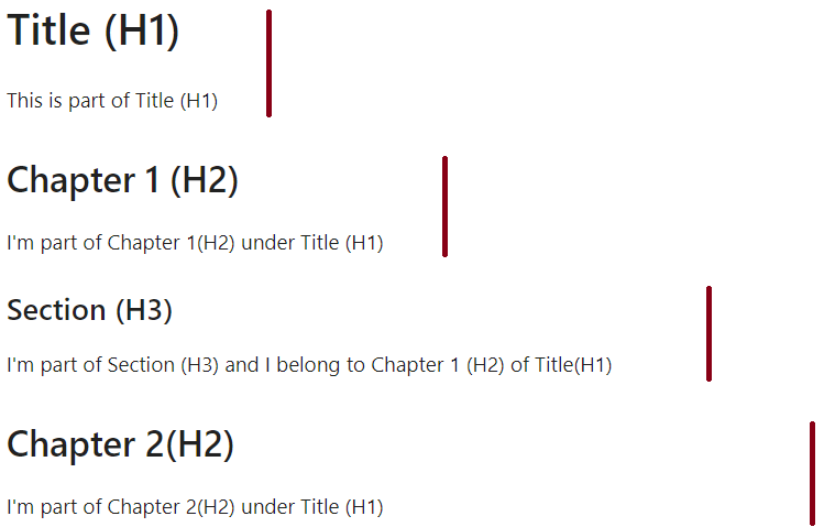

In [ ]:
md_header_splits[0]

Document(page_content='This is part of Title (H1)', metadata={'Header 1': 'Title (H1)'})

In [ ]:
md_header_splits[1]

Document(page_content="I'm part of Chapter 1(H2) under Title (H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 1 (H2)'})

In [ ]:
md_header_splits[2]

Document(page_content="I'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 1 (H2)', 'Header 3': 'Section (H3)'})

In [ ]:
md_header_splits[3]

Document(page_content="I'm part of Chapter 2(H2) under Title (H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 2(H2)'})

Now let's ignore the split at H2

In [ ]:
# We define the hierarchy of headers to split on. First H1, then H2 followed by H3
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on) # define MarkdownHeaderTextSplitter
md_header_splits = markdown_splitter.split_text(markdown_document)

In [ ]:
len(md_header_splits)

3

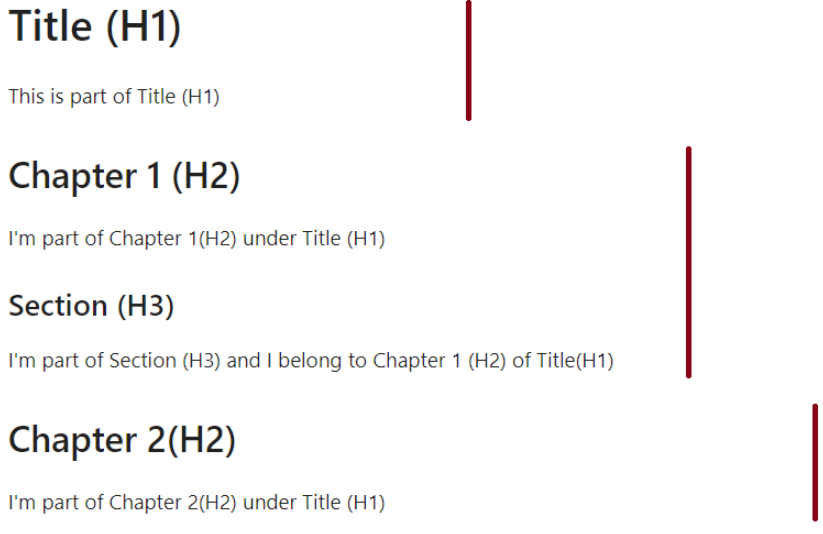

In [ ]:
md_header_splits

[Document(page_content='This is part of Title (H1)', metadata={'Header 1': 'Title (H1)'}),
 Document(page_content="I'm part of Chapter 1(H2) under Title (H1)  \n### Section (H3)  \nI'm part of  Section (H3) and I belong to  Chapter 1 (H2) of Title(H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 1 (H2)'}),
 Document(page_content="I'm part of Chapter 2(H2) under Title (H1)", metadata={'Header 1': 'Title (H1)', 'Header 2': 'Chapter 2(H2)'})]

#### TextSplitter for our PDF

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, length_function = chunkByWord, chunk_overlap=50, add_start_index = False)
splits = text_splitter.split_documents(documents)
len(splits)

239

## Step3: Vector Stores & Embeddings

An embedding is a numerical representation of a piece of information - text, documents, images, audio, etc.

Now, let’s ingest documents into Faiss so we can efficiently query our embeddings

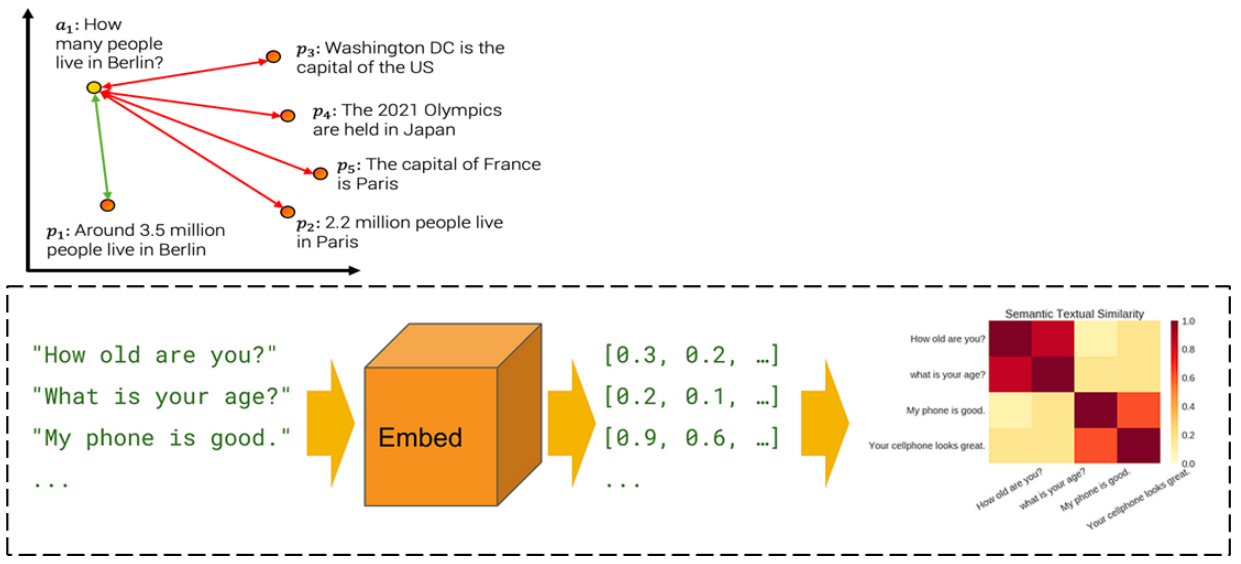


Vector databases are a new database category that stores vectors or embeddings. They also help in similarity searches.
Most popular ones are Pinecone & Weaviate. Chroma & FAISS are easy to work with locally.

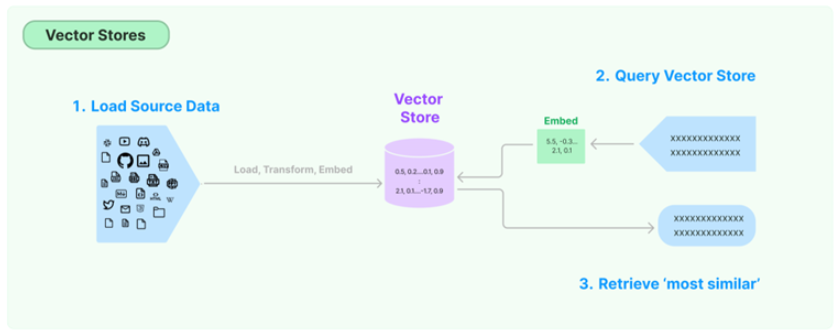

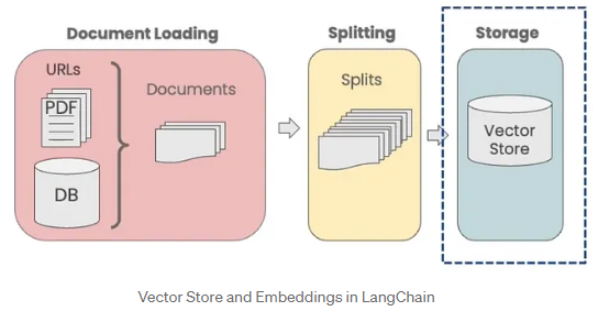

Now, we will create embeddings for all the chunks of the PDFs and then store them in a vector store. We use OpenAI to create these embeddings.

We will use Chroma as the vector store in our case. Chroma is lightweight and in memory making it easy to start with.

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

# Open AI way
embeddings = OpenAIEmbeddings()

# Azure Open AI way
# embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
#                               openai_api_key=EMBEDDING_API_KEY,
#                               openai_api_base=EMBEDDING_API_BASE,
#                               openai_api_version=API_VERSION,
#                               openai_api_type=API_TYPE,
#                               chunk_size=1)

We save this vector store in a persistent directory so that we can use it in future.

In [ ]:
from langchain.vectorstores import Chroma

persist_directory = os.getcwd() +'/vectorstore/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)

print(vectordb._collection.count())

239


### Easy Understanding so far...
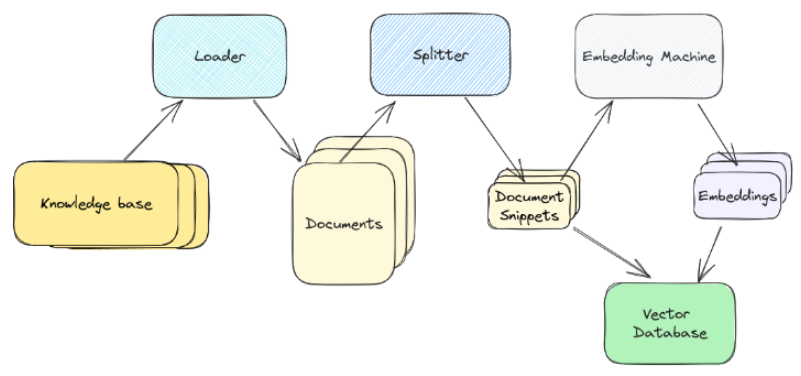

## Step4: Retrieval

Retrieval is the centrepiece of our retrieval augmented generation (RAG) flow. Retrieval is important at query time when a query comes in and we want to retrieve the most relevant splits.

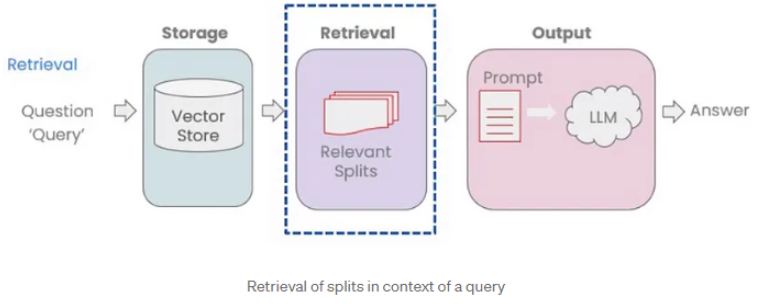

### Retrieve
Once the vector database is populated, you can define it as the retriever component, which fetches the additional context based on the semantic similarity between the user query and the embedded chunks.

In [ ]:
retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 3, "include_metadata": True})

### Augment
Next, to augment the prompt with the additional context, you need to prepare a prompt template. The prompt can be easily customized from a prompt template, as shown below.

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Avoid using generic phrases like "Provide context" or "as per context.

Question: {question}

Context: {context}

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

### Generate
Finally, you can build a chain for the RAG pipeline, chaining together the retriever, the prompt template and the LLM. Once the RAG chain is defined, you can invoke it.

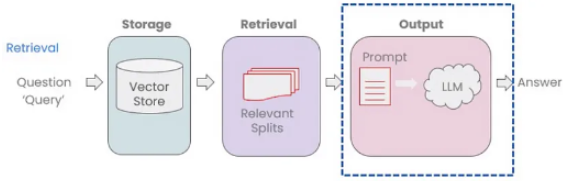

#### Memory Module

We can now create a memory object, which is necessary to track the inputs/outputs and hold a conversation.

In [ ]:
from langchain.memory import ConversationBufferMemory
from typing import Dict, Any

class CustomConversationBufferMemory(ConversationBufferMemory):
    def save_context(self, inputs: Dict[str, Any], outputs: Dict[str, str]) -> None:
        return super(CustomConversationBufferMemory, self).save_context(inputs,{'response': outputs['answer']})

# define memory object
memory = CustomConversationBufferMemory(memory_key="chat_history", return_messages=True)

#### LLM

We can now create a LLM object, which is necessary to answer questions using the context provided

In [ ]:
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI

# Open AI way
llm = ChatOpenAI(model="gpt-4-0125-preview",temperature=0)

# Azure Open AI way
# llm = AzureChatOpenAI(
#         openai_api_base=API_BASE,
#         openai_api_version=API_VERSION,
#         deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
#         openai_api_key=API_KEY,
#         openai_api_type=API_TYPE,
#         temperature=0
#     )

#### Chains

Lets define a chain as our last step which allow us to combine multiple components (all above defined) together to create a single, coherent application.

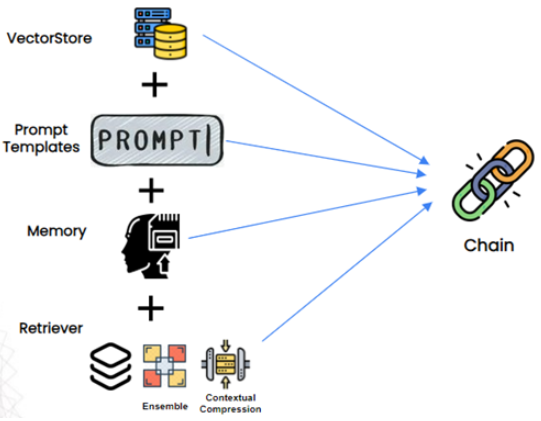

In [ ]:
from langchain.chains import ConversationalRetrievalChain
from IPython.display import Markdown

In [ ]:
chain = ConversationalRetrievalChain.from_llm(llm=llm,
                                           combine_docs_chain_kwargs={"prompt": prompt},
                                          retriever=retriever,
                                           memory=memory,
                                           return_source_documents=True)

In [ ]:
def pretty_print_result(result):
    """
    Custom function to print clean output
    """
    display(Markdown("Answer: " + result["answer"]))
    print("=============================================================================================================")
    display(Markdown(f"\n{'-.' * 100}\n\n".join([f"Document {i+1}:\n\n" + d.page_content +"\n\n" + str(d.metadata) for i, d in enumerate(result['source_documents'])])))
    return

In [ ]:
query = "Describe about Microsoft's Intelligent cloud"
result = chain({"question": query})
pretty_print_result(result)

Answer: Microsoft's Intelligent Cloud includes public, private, and hybrid server products and cloud services designed to power modern business and developers. It primarily comprises Azure and other cloud services, server products like SQL Server, Windows Server, Visual Studio, System Center, and related Client Access Licenses (CALs), as well as Nuance and GitHub. Additionally, it includes Enterprise Services such as Enterprise Support Services, Industry Solutions, and Nuance professional services.

Document 1:

Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can 
power modern business and developers. This segment primarily comprises:  
• Server products and cloud services, including Azure and other cloud services; SQL Server, Windows 
Server, Visual Studio, System Center, and related Client Access Licenses (“CALs”); and Nuance and 
GitHub.  
• Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft 
Consulting Services ), and Nuance professional services.  
Server Products and Cloud Services  
Azure is a comprehensive set of cloud services that offer developers, IT professionals, and enterprises freedom to 
build, deploy, and manage applications on any platform or device. Customers can use Azure through our global network 
of datacenters for compu ting, networking, storage, mobile and web application services, AI, IoT, cognitive services, 
and machine learning. Azure enables customers to devote more resources to development and use of applications 
that benefit their organizations, rather than managin g on-premises hardware and software. Azure revenue is mainly 
affected by infrastructure -as-a-service and platform -as-a-service consumption -based services, and per user -based 
services such as Enterprise Mobility + Security.  
Azure AI offerings provide a competitive advantage as companies seek ways to optimize and scale their business with 
machine learning. Azure’s purpose -built, AI -optimized infrastructure allows advanced models, including GPT -4 
services designed for developer s and data scientists, to do more with less. Customers can integrate large language 
models and develop the next generation of AI apps and services.

{'page': 11, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

comprises:  
• Office Commercial (Office 365 subscriptions, the Office 365 portion of Microsoft 365 Commercial 
subscriptions, and Office licensed on -premises), comprising Office, Exchange, SharePoint, Microsoft 
Teams, Office 365 Security and Compliance, Microsoft Viva , and Microsoft 365 Copilot . 
• Office Consumer, including Microsoft 365 Consumer  subscriptions, Office licensed on -premises, and other 
Office services.  
• LinkedIn, including Talent Solutions, Marketing Solutions, Premium Subscriptions, and Sales Solutions.  
• Dynamics business solutions, including Dynamics 365, comprising a set of intelligent, cloud -based 
applications across ERP, CRM  (including Customer Insights) , Power Apps, and Power Automate ; and on -
premises ERP and CRM applications.  
Intelligent Cloud  
Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can 
power modern business and developers. This segment primarily comprises:  
• Server products and cloud services, including Azure and other cloud services; SQL Server, Windows 
Server, Visual Studio, System Center, and related Client Access Licenses (“CALs”); and Nuance and 
GitHub.  
• Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft 
Consulting Services ), and Nuance professional services.

{'page': 89, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

PART I  
Item 1 
 
4 The Ambitions That Drive Us  
To achieve our vision, our research and development efforts focus on three interconnected ambitions:  
• Reinvent productivity and business processes.  
• Build the intelligent cloud and intelligent edge platform.  
• Create more personal computing.  
Reinvent Productivity and Business Processes  
At Microsoft, we provide technology and resources to help our customers create a secure , productive  work 
environment. Our family of products plays a key role in the ways the world works, learns, and connects.  
Our growth depends on securely delivering continuous innovation and advancing our leading productivity and 
collaboration tools and services, including Office 365, Dynamics 365, and LinkedIn. Microsoft 365 brings together 
Office 365, Windows, and Enterprise  Mobility + Security to help organizations empower their employees with AI -backed 
tools that unlock creativity, increase collaboration, and fuel innovation, all the while enabling compliance coverage and 
data protection. Microsoft Teams is a comprehensive platform for work, with meetings, calls, chat, collaboration, and 
business process automation. Microsoft Viva is an employee experience platform that brings together communications, 
knowledge, learning, resources, and insights. Microsoft 365 Copilot combines next -generation AI with business data 
in the Microsoft Graph and Microsoft 365 applications.  
Together with the Microsoft Cloud, Dynamics 365, Microsoft Teams, and our AI offerings  bring a new era of 
collaborative applications that optimize  business function s, process es, and applications to better serve customers and 
employees while creating more business value . Microsoft Power Platform is helping domain experts drive productivity 
gains with low -code/no -code tools, robotic process automation, virtual agents, and business intelligence. In a dynamic 
labor market, LinkedIn is helping professionals use the platform to connect, learn, grow, and get hired.  
Build the Intelligent Cloud and Intelligent Edge Platform  
As digital transformation and adoption of AI accelerates  and revolutionizes more business workstreams , organizations 
in every sector across the globe can address challenges that will have a fundamental impact on their success. For 
enterprises, digital technology empowers employees, optimizes operations, engages customers, and in some cases, 
changes the ve ry core of products and services. We continue to invest in high performance and sustainable computing 
to meet the growing demand for fast access to Microso ft services provided by our network of cloud computing 
infrastructure and datacenters.  
Our cloud business benefits from three economies of scale: datacenters that deploy computational resources at 
significantly lower cost per unit than smaller ones; datacenters that coordinate and aggregate diverse customer,

{'page': 4, 'source': '/content/RAG/data/Microsoft_2023.pdf'}

In [ ]:
query = "What is Microsoft's growth rate in revenue?"
pretty_print_result(chain({"question": query}))

Answer: The overall growth rate in revenue for Microsoft is not explicitly stated in the provided context. However, various segments of Microsoft's business experienced different growth rates, such as a 10% increase in LinkedIn revenue, a 16% increase in Dynamics products and cloud services revenue, and a 19% increase in server products and cloud services revenue. Additionally, Intelligent Cloud revenue increased by 17%.

Document 1:

subscribers increased to 67.0 million.  
• LinkedIn revenue increased  10%. 
• Dynamics products and cloud services revenue increased  16% driven by Dynamics 365 growth of 24%. 
• Server products and cloud services revenue increased  19% driven by Azure and other cloud services 
growth of 29%. 
• Windows original equipment manufacturer licensing (“Windows OEM”) revenue decreased  25%. 
• Devices revenue decreased  24%. 
• Windows Commercial products and cloud services revenue increased  5%. 
• Xbox content and services revenue decreased  3%.  
• Search and news advertising revenue excluding traffic acquisition costs increased  11%. 
Industry Trends  
Our industry is dynamic and highly competitive, with frequent changes in both technologies and business models. Each 
industry shift is an opportunity to conceive new products, new technologies, or new ideas that can further transform 
the industry and our business. At Microsoft, we push the boundaries of what is possible through a broad range of 
research and development activities that seek to identify and address the changing demands of customers and users, 
industry trends, and competitive forces.

{'page': 36, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

driven by continued customer shift to cloud offerings.  
• Office Consumer products and cloud services revenue increased $ 140 million or 2%. Microsoft 365 
Consumer subscribers grew 12% to 67.0 million.   
• LinkedIn revenue increased $1. 3 billion or 10% driven by Talent Solutions.  
• Dynamics products and cloud services revenue increased $750 million or 16% driven by Dynamics 365 
growth of 24%. 
Operating income increased  $4.5 billion or 15%.  
• Gross margin increased  $5.8 billion or 12% driven by growth in Office 365 Commercial  and LinkedIn , as 
well as the change in accounting estimate. Gross margin percentage increased. Excluding the impact of the 
change in accounting estimate, gross margin percentage increased slightly  driven by improvement in Office 
365 Commercial, offset in part by sales mix shift to cloud offerings.  
• Operating expenses increased  $1.3 billion or 7% driven by investment in LinkedIn and employee severance 
expenses.  
Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 5%, 5%, and 8%, 
respectively.  
Intelligent Cloud  
Revenue increased  $12.9  billion or 17%. 
• Server products and cloud services revenue increased $ 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased $ 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

commercial and consumer businesses. As we have diversity of target audiences and sales motio ns within the Windows 
business, we monitor metrics that are reflective of those varying motions.  
 
Windows OEM revenue growth  
  Revenue from sales of Windows Pro and non -Pro licenses sold through 
the OEM channel  
   Windows Commercial products and cloud 
services revenue growth  
  Revenue from Windows Commercial products and cloud services, 
comprising volume licensing of the Windows operating system, 
Windows cloud services, and other Windows commercial offerings  
   Devices revenue growth  
  Revenue from Devices, including Surface, HoloLens, and PC 
accessories  
   Xbox content and services revenue 
growth  
  Revenue from Xbox content and services, comprising first - and third -
party content (including games and in -game content), Xbox Game Pass 
and other subscriptions, Xbox Cloud Gaming, advertising, third-party 
disc royalties, and other cloud services  
   Search and news advertising revenue (ex 
TAC) growth    Revenue from search and news advertising excluding traffic acquisition 
costs (“TAC”) paid to Bing Ads network publishers and news partners

{'page': 39, 'source': '/content/RAG/data/Microsoft_2023.pdf'}